In [ ]:
#import necessary libraries

In [98]:
import torch 
import torch.nn as nn
from  torchvision import datasets,transforms
import torchvision.models as models
from torch.utils.data import TensorDataset,DataLoader

import torch.optim as optim
import torch.nn.functional as F
import time
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [100]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
#device configuration

In [102]:
device = torch.device("cuda" if torch.cuda.is_available() else "mps")
device

device(type='mps')

In [ ]:
## load data
# We know that if  the size of the images is smaller,the model will train faster, for that we need to apply a transformation

In [212]:
image_transform=transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2,contrast=0.2),
    transforms.ToTensor(),
    transforms.Resize((224,224)),
    transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])#these values of mean and std taken from imagenet model
])


In [214]:
path="./dataset"

dataset = datasets.ImageFolder(root=path, transform = image_transform)
#we need to use(imagefolder) this when we have the data in the form of images

len(dataset)

2300

In [216]:
#whatever subfolders names are there it will implicitly assumme thier classes

classes=dataset.classes
classes

['F_Breakage', 'F_Crushed', 'F_Normal', 'R_Breakage', 'R_Crushed', 'R_Normal']

In [218]:
num_classes=len(dataset.classes)
num_classes

6

In [220]:
from sklearn.model_selection import train_test_split
train_size=int(len(dataset)*0.75)
train_size

1725

In [222]:
val_size=len(dataset)-train_size
val_size

575

In [224]:
#split using random split
from torch.utils.data import random_split

train_dataset,val_dataset = random_split(dataset,[train_size,val_size])

In [226]:
#dataloader


train_loader=DataLoader(train_dataset,shuffle=True,batch_size=32)
val_loader=DataLoader(val_dataset,shuffle=True,batch_size=32)

In [228]:
#visualisation

for images,labels in train_loader:
    print(images.shape)
    print(labels.shape)
    break
#here 1725 size of train loader, after creating batches size of 32,for loop iterates over each batch 
#[batch_size, channel, size of image]

torch.Size([32, 3, 224, 224])
torch.Size([32])


In [122]:
images.shape #32 images in a batch 

torch.Size([32, 3, 224, 224])

In [124]:
images[0].shape #first image from 1 batch

torch.Size([3, 224, 224])

In [126]:
labels[0]

tensor(5)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.46982].


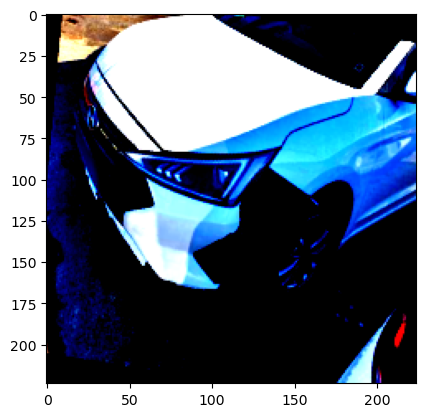

In [230]:
plt.imshow(images[0].permute(1,2,0))
#permute helps in reordering dimensions like 1 to last 
plt.show()
# The image is not clear because we have normalized the images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.46982].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.326274].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.843908..2.151983].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.0822656].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0151556..2.2641835].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0836544..2.3959923].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.1637

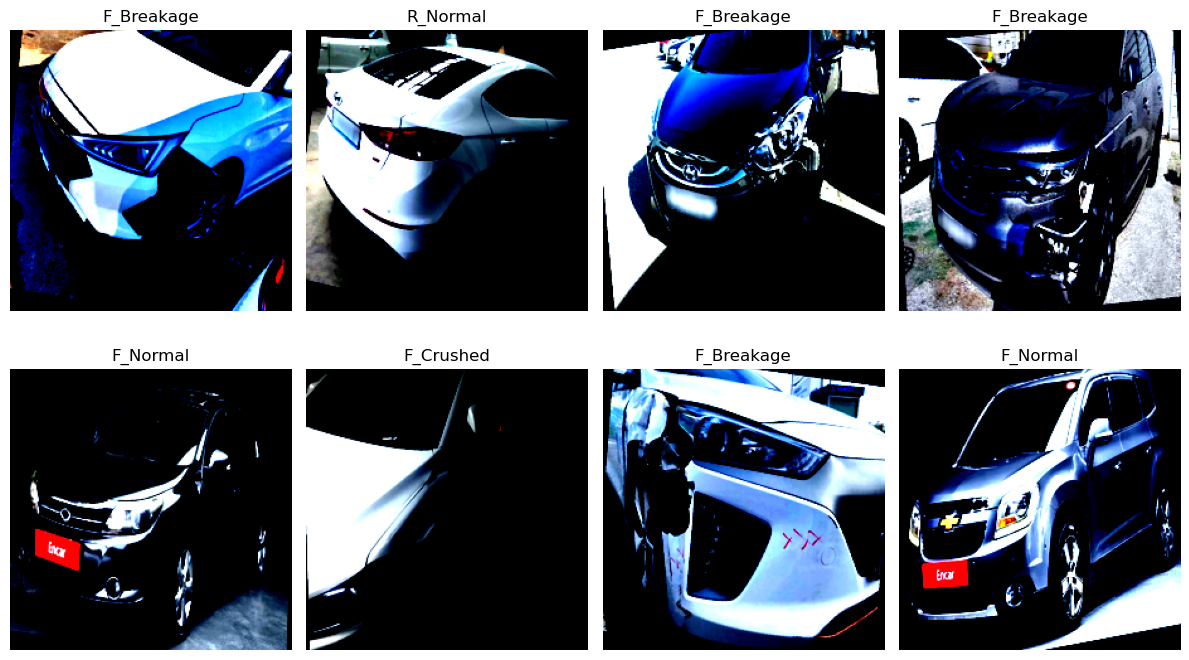

In [232]:
plt.figure(figsize=(12,8))

for i in range(8):
    plt.subplot(2, 4, i+1)
    #images[i]=images[i]/2+0.5 #unnormalize
    #npimg = images[i].cpu().numpy()
    plt.imshow(np.transpose(images[i],(1,2,0)))
    plt.title(f"{classes[labels[i]]}")
    plt.axis('off')
    plt.tight_layout()
plt.show()
#Your current image data contains values greater than 1.0 (e.g., 1.089206, 1.4100003), which causes matplotlib to clip them — 
#i.e., forcibly set values above 1.0 to 1.0.

In [ ]:
#model 1: CNN

In [146]:
class CarClassifierCNN(nn.Module):
    def __init__(self,num_classes):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels=16,kernel_size=3,stride=1,padding=1),#3*224*224>>16*224*224
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),#16*224*224>>16*112*112
            nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3,stride=1,padding=1),#16*112*112>>32*112*112
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),#32*112*112>>32*56*56
            nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=1,padding=1),#64*56*56
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),#64*56*56>64*28*28
            nn.Flatten(),
            nn.Linear(64*28*28,512),
            nn.ReLU(),
            nn.Linear(512,num_classes)
        )
        
        
    def forward(self,x):
        x=self.network(x)
        return x      

In [156]:
num_classes

6

In [158]:

#intiate the model,lossfunction, and optimizer

model=CarClassifierCNN(num_classes=num_classes).to(device)
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(),lr=0.001)

In [176]:
def train_val(model,train_loader,val_loader,optimizer,criterion,epochs=5):
    start=time.time()
    for epoch in range(epochs):
        model.train()
        training_loss=0
        
        for batch,(images,labels) in enumerate(train_loader):
            images,labels=images.to(device),labels.to(device)
            
            # Initialize gradients to zero
            optimizer.zero_grad()
            #forward pass
            outputs=model(images)
            loss=criterion(outputs,labels)
            #backward pass
            loss.backward()
            optimizer.step()
            training_loss+=loss.item()* images.size(0)

            if (batch+1)%10==0:
                print(f" batch : {batch+1} ,epoch :{epoch+1} , loss :{loss.item():0.2f}")

        epoch_loss = training_loss/len(train_loader.dataset)
        print(f"epoch {epoch+1}/{epochs}, avg loss : {epoch_loss:.4f}")



        model.eval()
        correct=0
        total=0
        all_labels=[]
        all_predictions=[]
        with torch.no_grad():
            for images,labels in val_loader:
                images,labels=images.to(device),labels.to(device)
                output=model(images)
                _,pred=torch.max(output.data,1)
                correct+=(labels==pred).sum().item()
                total+=labels.size(0)
                all_labels.extend(labels.cpu().numpy())
                all_predictions.extend(pred.cpu().numpy())

            print(f"*** validation accuracy :{100*correct/total:.2f}***")

    end=time.time()
    print(f"execution time:{end-start} seconds")
    return all_labels,all_predictions 

In [178]:
all_labels,preddicted_labels= train_val(model,train_loader,val_loader,optimizer,criterion,epochs=5)

 batch : 10 ,epoch :1 , loss :1.32
 batch : 20 ,epoch :1 , loss :1.03
 batch : 30 ,epoch :1 , loss :1.12
 batch : 40 ,epoch :1 , loss :1.24
 batch : 50 ,epoch :1 , loss :0.91
epoch 1/5, avg loss : 1.1110
*** validation accuracy :50.78***
 batch : 10 ,epoch :2 , loss :0.90
 batch : 20 ,epoch :2 , loss :0.70
 batch : 30 ,epoch :2 , loss :0.88
 batch : 40 ,epoch :2 , loss :0.85
 batch : 50 ,epoch :2 , loss :1.08
epoch 2/5, avg loss : 1.0031
*** validation accuracy :51.13***
 batch : 10 ,epoch :3 , loss :0.98
 batch : 20 ,epoch :3 , loss :0.96
 batch : 30 ,epoch :3 , loss :0.85
 batch : 40 ,epoch :3 , loss :0.96
 batch : 50 ,epoch :3 , loss :1.01
epoch 3/5, avg loss : 0.8946
*** validation accuracy :58.26***
 batch : 10 ,epoch :4 , loss :1.31
 batch : 20 ,epoch :4 , loss :0.77
 batch : 30 ,epoch :4 , loss :0.67
 batch : 40 ,epoch :4 , loss :0.59
 batch : 50 ,epoch :4 , loss :0.95
epoch 4/5, avg loss : 0.8335
*** validation accuracy :56.52***
 batch : 10 ,epoch :5 , loss :0.80
 batch : 20 ,

In [ ]:
#model-2 Cnn with regularization

In [180]:
class CarClassifierCNNWithRegularisation(nn.Module):
    def __init__(self,num_classes):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels=16,kernel_size=3,stride=1,padding=1),#3*224*224>>16*224*224
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),#16*224*224>>16*112*112
            nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3,stride=1,padding=1),#16*112*112>>32*112*112
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),#32*112*112>>32*56*56
            nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=1,padding=1),#64*56*56
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),#64*56*56>64*28*28
            nn.Flatten(),
            nn.Linear(64*28*28,512),
            nn.ReLU(),
            nn.Dropout2d(p=0.5),
            nn.Linear(512,num_classes)
        )
        
        
    def forward(self,x):
        x=self.network(x)
        return x  

In [186]:
model_2=CarClassifierCNNWithRegularisation(num_classes=num_classes).to(device)
criterion=nn.CrossEntropyLoss()
optimizer_2=optim.Adam(model.parameters(),lr=0.001,weight_decay=1e-4)

In [188]:
all_labels,preddicted_labels= train_val(model_2,train_loader,val_loader,optimizer_2,criterion,epochs=5)

 batch : 10 ,epoch :1 , loss :1.84
 batch : 20 ,epoch :1 , loss :1.88
 batch : 30 ,epoch :1 , loss :1.89
 batch : 40 ,epoch :1 , loss :1.73
 batch : 50 ,epoch :1 , loss :1.85
epoch 1/5, avg loss : 1.8690
*** validation accuracy :12.52***
 batch : 10 ,epoch :2 , loss :1.78
 batch : 20 ,epoch :2 , loss :1.91
 batch : 30 ,epoch :2 , loss :1.95
 batch : 40 ,epoch :2 , loss :1.84
 batch : 50 ,epoch :2 , loss :1.90
epoch 2/5, avg loss : 1.8543
*** validation accuracy :12.00***
 batch : 10 ,epoch :3 , loss :1.95
 batch : 20 ,epoch :3 , loss :1.83
 batch : 30 ,epoch :3 , loss :1.95
 batch : 40 ,epoch :3 , loss :1.84
 batch : 50 ,epoch :3 , loss :1.93
epoch 3/5, avg loss : 1.8589
*** validation accuracy :12.52***
 batch : 10 ,epoch :4 , loss :1.83
 batch : 20 ,epoch :4 , loss :1.89
 batch : 30 ,epoch :4 , loss :1.80
 batch : 40 ,epoch :4 , loss :1.81
 batch : 50 ,epoch :4 , loss :1.88
epoch 4/5, avg loss : 1.8682
*** validation accuracy :12.00***
 batch : 10 ,epoch :5 , loss :1.73
 batch : 20 ,

In [190]:
#model- 3 Transfer learning with efficient net

In [192]:
model=models.efficientnet_b0(weights="DEFAULT")
model.classifier[1].in_features

1280

In [194]:
class CarclassifierwithEfficientnet(nn.Module):
    def __init__(self,num_classes):
        super().__init__()
        self.model=models.efficientnet_b0(weights="DEFAULT")

        for params in self.model.parameters():
            params.requires_grad=False

        in_features=self.model.classifier[1].in_features
        self.model.classifier=nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(in_features,num_classes))
        
    def forward(self,x):
        x=self.model(x)
        return x

In [204]:
model_3=CarclassifierwithEfficientnet(num_classes=num_classes).to(device)
criterion=nn.CrossEntropyLoss()
optimizer_3=optim.Adam(filter(lambda p : p.requires_grad,model.parameters()),lr=0.001)

In [202]:
#example for above equation
list(filter(lambda x : x%2==0,[1,2,3,4,5,6,7,8]))

[2, 4, 6, 8]

In [206]:
all_labels,preddicted_labels= train_val(model_3,train_loader,val_loader,optimizer_3,criterion,epochs=5)

 batch : 10 ,epoch :1 , loss :1.73
 batch : 20 ,epoch :1 , loss :1.78
 batch : 30 ,epoch :1 , loss :1.83
 batch : 40 ,epoch :1 , loss :1.84
 batch : 50 ,epoch :1 , loss :1.90
epoch 1/5, avg loss : 1.8325
*** validation accuracy :15.13***
 batch : 10 ,epoch :2 , loss :1.84
 batch : 20 ,epoch :2 , loss :1.77
 batch : 30 ,epoch :2 , loss :1.88
 batch : 40 ,epoch :2 , loss :1.88
 batch : 50 ,epoch :2 , loss :1.84
epoch 2/5, avg loss : 1.8303
*** validation accuracy :16.52***
 batch : 10 ,epoch :3 , loss :1.95
 batch : 20 ,epoch :3 , loss :1.82
 batch : 30 ,epoch :3 , loss :1.83
 batch : 40 ,epoch :3 , loss :1.90
 batch : 50 ,epoch :3 , loss :1.84
epoch 3/5, avg loss : 1.8306
*** validation accuracy :15.48***
 batch : 10 ,epoch :4 , loss :1.83
 batch : 20 ,epoch :4 , loss :1.84
 batch : 30 ,epoch :4 , loss :1.86
 batch : 40 ,epoch :4 , loss :1.82
 batch : 50 ,epoch :4 , loss :1.87
epoch 4/5, avg loss : 1.8293
*** validation accuracy :14.09***
 batch : 10 ,epoch :5 , loss :1.82
 batch : 20 ,

In [ ]:
#model 4 Transfer learning - Resnet 50

In [238]:
class CarclassifierResent50(nn.Module):
    def __init__(self,num_classes,dropout_rate=0.5):
        super().__init__()
        self.model = models.resnet50(weights="DEFAULT")
        # Let's freeze all layers except the final fully connected layer 
        for params in self.model.parameters():
            params.requires_grad=False

        # unfreeze layer 4 
        for params in self.model.layer4.parameters():
            params.requires_grad=True
        self.model.fc=nn.Sequential(nn.Dropout(dropout_rate),nn.Linear(self.model.fc.in_features,num_classes))

    def forward(self,x):
            x=self.model(x)
            return x

In [240]:
model_4=CarclassifierResent50(num_classes=num_classes).to(device)
criterion=nn.CrossEntropyLoss()
optimizer_4=optim.Adam(filter(lambda p : p.requires_grad,model.parameters()),lr=0.001)

In [242]:
all_labels,preddicted_labels= train_val(model_4,train_loader,val_loader,optimizer_4,criterion,epochs=5)

 batch : 10 ,epoch :1 , loss :1.79
 batch : 20 ,epoch :1 , loss :1.82
 batch : 30 ,epoch :1 , loss :1.77
 batch : 40 ,epoch :1 , loss :1.78
 batch : 50 ,epoch :1 , loss :1.77
epoch 1/5, avg loss : 1.7979
*** validation accuracy :15.13***
 batch : 10 ,epoch :2 , loss :1.77
 batch : 20 ,epoch :2 , loss :1.78
 batch : 30 ,epoch :2 , loss :1.80
 batch : 40 ,epoch :2 , loss :1.78
 batch : 50 ,epoch :2 , loss :1.80
epoch 2/5, avg loss : 1.7952
*** validation accuracy :17.57***
 batch : 10 ,epoch :3 , loss :1.82
 batch : 20 ,epoch :3 , loss :1.84
 batch : 30 ,epoch :3 , loss :1.77
 batch : 40 ,epoch :3 , loss :1.79
 batch : 50 ,epoch :3 , loss :1.78
epoch 3/5, avg loss : 1.7968
*** validation accuracy :14.26***
 batch : 10 ,epoch :4 , loss :1.81
 batch : 20 ,epoch :4 , loss :1.79
 batch : 30 ,epoch :4 , loss :1.78
 batch : 40 ,epoch :4 , loss :1.79
 batch : 50 ,epoch :4 , loss :1.80
epoch 4/5, avg loss : 1.8014
*** validation accuracy :15.48***
 batch : 10 ,epoch :5 , loss :1.79
 batch : 20 ,

I performed hyperparameter tuning in a separate notebook and identified the optimal parameters for training the ResNet model. Based on the results, the best configuration is:

Dropout Rate: 0.6

Learning Rate: 0.0012

With these best parameters, I will now proceed to retrain the model to evaluate its performance.

In [249]:
model = CarclassifierResent50(num_classes=num_classes, dropout_rate=0.6).to(device)
criterion=nn.CrossEntropyLoss()
optimizer_4=optim.Adam(filter(lambda p : p.requires_grad,model.parameters()),lr=0.001)

labels, predictions = train_val(model, train_loader,val_loader,optimizer_4,criterion, epochs=5)

 batch : 10 ,epoch :1 , loss :0.99
 batch : 20 ,epoch :1 , loss :1.07
 batch : 30 ,epoch :1 , loss :0.39
 batch : 40 ,epoch :1 , loss :0.79
 batch : 50 ,epoch :1 , loss :0.73
epoch 1/5, avg loss : 0.8639
*** validation accuracy :73.04***
 batch : 10 ,epoch :2 , loss :0.56
 batch : 20 ,epoch :2 , loss :0.60
 batch : 30 ,epoch :2 , loss :0.39
 batch : 40 ,epoch :2 , loss :0.90
 batch : 50 ,epoch :2 , loss :0.77
epoch 2/5, avg loss : 0.4896
*** validation accuracy :76.87***
 batch : 10 ,epoch :3 , loss :0.26
 batch : 20 ,epoch :3 , loss :0.16
 batch : 30 ,epoch :3 , loss :0.62
 batch : 40 ,epoch :3 , loss :0.27
 batch : 50 ,epoch :3 , loss :0.49
epoch 3/5, avg loss : 0.3242
*** validation accuracy :76.87***
 batch : 10 ,epoch :4 , loss :0.17
 batch : 20 ,epoch :4 , loss :0.41
 batch : 30 ,epoch :4 , loss :0.17
 batch : 40 ,epoch :4 , loss :0.29
 batch : 50 ,epoch :4 , loss :0.19
epoch 4/5, avg loss : 0.2175
*** validation accuracy :77.04***
 batch : 10 ,epoch :5 , loss :0.14
 batch : 20 ,

In [ ]:
#Model evaluation using confusion matrix and classification report

In [251]:
from sklearn.metrics import classification_report

report = classification_report(labels, predictions)
print(report)

              precision    recall  f1-score   support

           0       0.90      0.77      0.83       120
           1       0.61      0.93      0.73       101
           2       0.99      0.73      0.84       130
           3       0.75      0.78      0.76        81
           4       0.76      0.40      0.52        73
           5       0.62      0.89      0.73        70

    accuracy                           0.76       575
   macro avg       0.77      0.75      0.74       575
weighted avg       0.80      0.76      0.75       575



In [259]:
conf_matrix = confusion_matrix(labels, predictions, labels=np.arange(num_classes))
conf_matrix

array([[92, 28,  0,  0,  0,  0],
       [ 6, 94,  1,  0,  0,  0],
       [ 1, 32, 95,  0,  0,  2],
       [ 2,  0,  0, 63,  5, 11],
       [ 0,  1,  0, 18, 29, 25],
       [ 1,  0,  0,  3,  4, 62]])

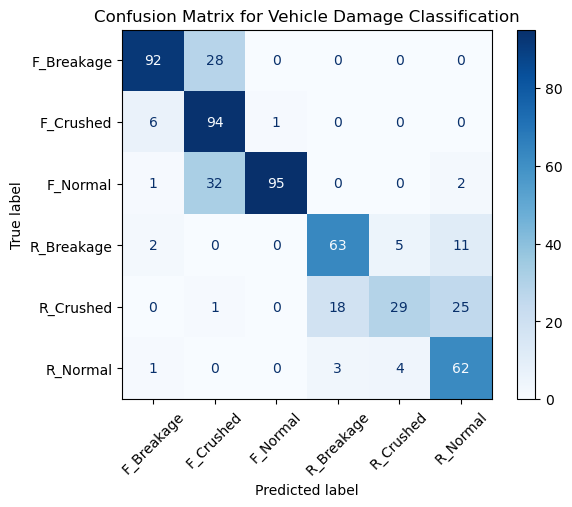

In [255]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib import pyplot as plt

conf_matrix = confusion_matrix(labels, predictions, labels=np.arange(num_classes))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=classes)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix for Vehicle Damage Classification")
plt.show()

In [ ]:
#save the model

In [257]:
torch.save(model.state_dict(), 'saved_model.pth')